In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MABarbadillo/
%cd 'SPTProject/Rosetta'
import os

In [ ]:
##Install rosetta

!pip install rosetta-soil
from rosetta import rosetta, SoilData

In [4]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [ ]:
####This calculates the daily hydraulic conductivity values using the Illston et al. (2008) and the Zhang et al. (2019) matric potential equations

##Daily delta reference temperatures at 60 cm depth for ACME site were taken from 'ACMEdeltaT.mat' file
##deltaT were then converted to matric potential values using two equations (i.e., Illston et al., 2008, and Zhang et.al., 2019)
##'MesoSoilv1_3.csv' file was loaded to  get the soil properties (%sand, silt, clay, bulk density, water contents at -33 and -1500 kPa) and K0 at 60 cm depth for ACME site
##Hydraulic parameters (thetas, thetar, alpha, n, Ks) were estimated using Rosetta verrsions 1 and 3
##Volumetric water contents were calculated for both matric potential equations and for both versions of Rosetta
##Effective saturation (Se) was calculated for both matric potential equations and for both versions of Rosetta
##Daily hydraulic conductivity (K) values were calculated for both matric potential equations and for both versions of Rosetta

##A comparison between the K values obtained using K0+Rosetta V1 parameters and K0+Rosetta V3 parameters was made for both matric potential equations


In [ ]:
### STEPS

# Loading the matlab file 'ACMEdeltaT.mat'
acme_data = loadmat('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/ACMEdeltaT.mat')
df = pd.DataFrame(acme_data['ACMEdeltaT'])
tr60_data = [float(df.iloc[i, 4]) for i in range(2, len(df))]   #Extracts the TR60 starting from row 3 in column 5 as a float (python starts counting at 0)

# Calculate the matric_potential using Illston et al. (2008) equation
c = 0.717    #kPa
a = 1.788    #1/degree Celcius
mp_60_Ill = [-c*np.exp(a*tr60_data[i]) for i in range(len(tr60_data))]   #kPa

# Calculate the matric_potential using Zhang et al. (2019) equation
mp_60_Zha = [-2083/(1+np.exp(-3.35*(tr60_data[i]-3.17))) for i in range(len(tr60_data))]    #kPa

# Read the 'MesoSoilv1_3.csv' file, skipping the first row
# Integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/MesoSoilv1_3.csv', header=0, skiprows=1)
data = df1.iloc[5: , [2, 3, 4, 5, 6, 7]].values.tolist()   #integer 5 specifies that the data reading starts at the 6th row (data at 60 cm depth is at the 6th row)
K0 = float(df1.iloc[5, 13])

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

# Extract the hydraulic parameter values from the array
# Rosetta Ver.1
theta_r1 = float(mean_1[0][0])    #everything is at the first row
theta_s1 = float(mean_1[0][1])
alpha1 = 10**float(mean_1[0][2])
n1 = 10**float(mean_1[0][3])
m1 = 1 - (1 / n1)
Ks_1 = 10**float(mean_1[0][4])

# Rosetta Ver.3
theta_r3 = float(mean_3[0][0])
theta_s3 = float(mean_3[0][1])
alpha3 = 10**float(mean_3[0][2])
n3 = 10**float(mean_3[0][3])
m3 = 1 - (1 / n3)
Ks_3 = 10**float(mean_3[0][4])


# Converting Illston et al. (2008) matric potential to volumetric water content (vwc) [cm3/cm3]
# Rosetta Ver.1
vwc1_Ill = [theta_r1 + (theta_s1 - theta_r1) * (1 + (-alpha1 * mp_60_Ill[i])**n1)**-m1 for i in range(len(mp_60_Ill))]
# Rosetta Ver.3
vwc3_Ill = [theta_r3 + (theta_s3 - theta_r3) * (1 + (-alpha3 * mp_60_Ill[i])**n3)**-m3 for i in range(len(mp_60_Ill))]

# Converting Zhang et al. (2019) matric potential to volumetric water content (vwc) [cm3/cm3]
# Rosetta Ver.1
vwc1_Zha = [theta_r1 + (theta_s1 - theta_r1) * (1 + (-alpha1 * mp_60_Zha[i])**n1)**-m1 for i in range(len(mp_60_Zha))]
# Rosetta Ver.3
vwc3_Zha = [theta_r3 + (theta_s3 - theta_r3) * (1 + (-alpha3 * mp_60_Zha[i])**n3)**-m3 for i in range(len(mp_60_Zha))]


# Converting volumetric water content to effective saturation (Se) [cm3/cm3] [Illston et al., 2008]
# Rosetta Ver.1
Se1_Ill = [(vwc1_Ill[i] - theta_r1)/(theta_s1 - theta_r1) for i in range(len(vwc1_Ill))]
# Rosetta Ver.3
Se3_Ill = [(vwc3_Ill[i] - theta_r3)/(theta_s3 - theta_r3) for i in range(len(vwc3_Ill))]

# Converting volumetric water content to effective saturation (Se) [cm3/cm3] [Zhang et al., 2019]
# Rosetta Ver.1
Se1_Zha = [(vwc1_Zha[i] - theta_r1)/(theta_s1 - theta_r1) for i in range(len(vwc1_Zha))]
# Rosetta Ver.3
Se3_Zha = [(vwc3_Zha[i] - theta_r3)/(theta_s3 - theta_r3) for i in range(len(vwc3_Zha))]


# Calculating unsaturated hydraulic conductivity [cm/day]
L = 0.5   #default value

K_Se1_Ill = [Ks_1 * Se1_Ill[i]**L * (1 - (1 - Se1_Ill[i]**(1/m1))**m1)**2 for i in range(len(Se1_Ill))]
K_Se3_Ill = [Ks_3 * Se3_Ill[i]**L * (1 - (1 - Se3_Ill[i]**(1/m3))**m3)**2 for i in range(len(Se3_Ill))]
K_K0_Se1_Ill = [(K0*Se1_Ill[i]**L) * (1 - (1-Se1_Ill[i]**(n1/(n1-1)))**m1)**2 for i in range(len(Se1_Ill))]   #K0 + Rosetta V1 parameters
K_K0_Se3_Ill = [(K0*Se3_Ill[i]**L) * (1 - (1-Se3_Ill[i]**(n3/(n3-1)))**m3)**2 for i in range(len(Se3_Ill))]   #K0 + Rosetta V3 parameters
K_Se1_Zha = [Ks_1 * Se1_Zha[i]**L * (1 - (1 - Se1_Zha[i]**(1/m1))**m1)**2 for i in range(len(Se1_Zha))]
K_Se3_Zha = [Ks_3 * Se3_Zha[i]**L * (1 - (1 - Se3_Zha[i]**(1/m3))**m3)**2 for i in range(len(Se3_Zha))]
K_K0_Se1_Zha = [(K0*Se1_Zha[i]**L) * (1 - (1-Se1_Zha[i]**(n1/(n1-1)))**m1)**2 for i in range(len(Se1_Zha))]   #K0 + Rosetta V1 parameters
K_K0_Se3_Zha = [(K0*Se3_Zha[i]**L) * (1 - (1-Se3_Zha[i]**(n3/(n3-1)))**m3)**2 for i in range(len(Se3_Zha))]   #K0 + Rosetta V3 parameters


In [ ]:
# Printing of results

"""
print(K0)
print(theta_r1)
print(theta_r3)
print(theta_s1)
print(theta_s3)
print(alpha1)
print(alpha3)
print(n1)
print(n3)
print(m1)
print(m3)
print(Ks_1)
print(Ks_3)
print("vwc1_Ill:", vwc1_Ill)
print("vwc3_Ill:", vwc3_Ill)
print("vwc1_Zha:", vwc1_Zha)
print("vwc3_Zha:", vwc3_Zha)
print("Se1_Ill:", Se1_Ill)
print("Se3_Ill:", Se3_Ill)
print("Se1_Zha:", Se1_Zha)
print("Se3_Zha:", Se3_Zha)
"""
print("K_Se1_Ill:", K_Se1_Ill)
print("K_Se3_Ill:", K_Se3_Ill)
print("K_K0_Se1_Ill:", K_K0_Se1_Ill)
print("K_K0_Se3_Ill:", K_K0_Se3_Ill)
print("K_Se1_Zha:", K_Se1_Zha)
print("K_Se3_Zha:", K_Se3_Zha)
print("K_K0_Se1_Zha:", K_K0_Se1_Zha)
print("K_K0_Se3_Zha:", K_K0_Se3_Zha)

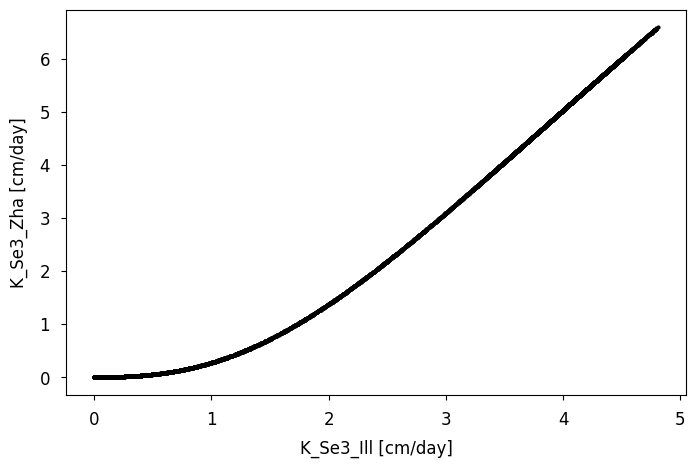

In [18]:
# Plotting of results

import matplotlib.pyplot as plt

# Plotting K values using Rosetta V3 for both Illston et al. (2008) and Zhang et al. (2019) MP equations
fig = plt.figure(figsize=(8,5))
plt.xlabel('K_Se3_Ill [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('K_Se3_Zha [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(K_Se3_Ill, K_Se3_Zha, 'ok', markersize=2)

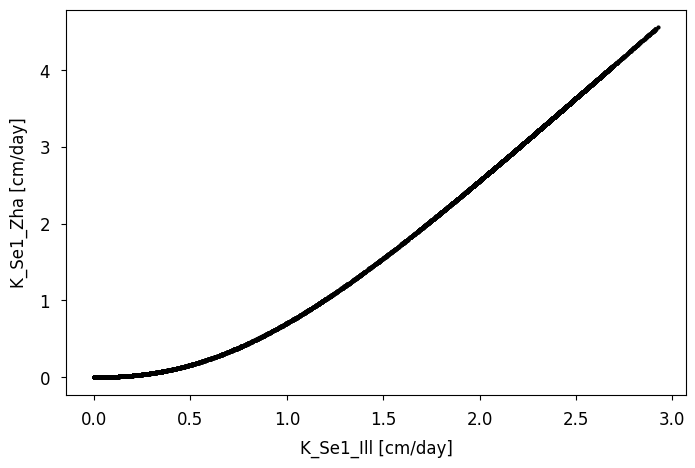

In [22]:
# Plotting K values using Rosetta V1 for both Illston et al. (2008) and Zhang et al. (2019) MP equations
fig = plt.figure(figsize=(8,5))
plt.xlabel('K_Se1_Ill [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('K_Se1_Zha [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(K_Se1_Ill, K_Se1_Zha, 'ok', markersize=2)

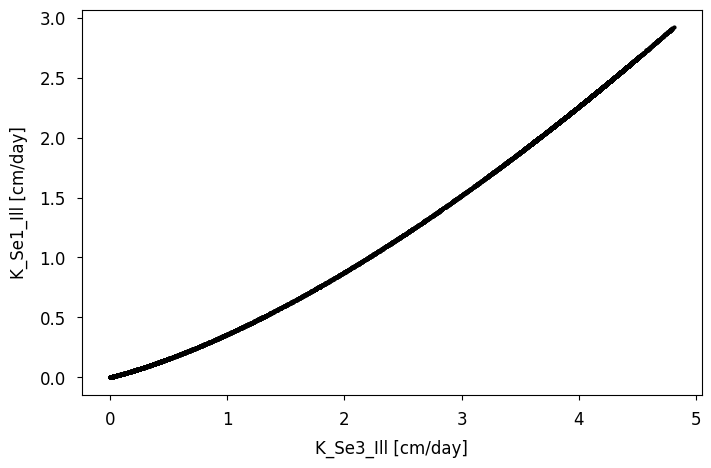

In [21]:
# Plotting K values using Illston et al. (2008) MP equations for both versions of Rosetta (V1 and V3)
fig = plt.figure(figsize=(8,5))
plt.xlabel('K_Se3_Ill [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('K_Se1_Ill [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(K_Se3_Ill, K_Se1_Ill, 'ok', markersize=2)

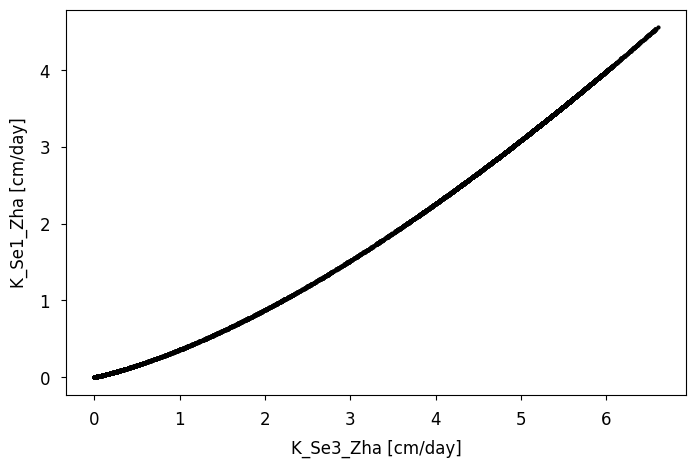

In [29]:
# Plotting K values using Zhang et al. (2019) MP equations for both versions of Rosetta (V1 and V3)
fig = plt.figure(figsize=(8,5))
plt.xlabel('K_Se3_Zha [cm/day]', fontsize=12, labelpad=8)
plt.ylabel('K_Se1_Zha [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12,pad=8)
plt.plot(K_Se3_Zha, K_Se1_Zha, 'ok', markersize=2)